In [1]:
import jax.numpy as jnp
import b3d
import os
import trimesh
import matplotlib.pyplot as plt
import jax

In [2]:
mesh_path = os.path.join(
    b3d.get_root_path(), "assets/shared_data_bucket/025_mug/textured.obj"
)
mesh = trimesh.load(mesh_path)
mesh.vertices = mesh.vertices - mesh.vertices.mean(axis=0)

object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_trimesh(mesh)

/opt/conda/envs/b3d/lib/python3.11/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)


In [3]:
print("Number of vertices: ", object_library.vertices.shape[0])


Number of vertices:  10689


In [4]:
def gaussian_logpdf(obs_image, rendered_image,b, multiplier, a, outlier_prob):
    probabilities = jax.scipy.stats.norm.logpdf(
        obs_image, rendered_image, multiplier
    )
    probabilities_adjusted = jnp.logaddexp(
        probabilities + jnp.log(1.0 - outlier_prob),
        jnp.log(outlier_prob)
    )
    return probabilities_adjusted.sum()

def gaussian_sample(key, rendered_image, b,multiplier, a, outlier_prob):
    return jax.random.normal(
        key, shape=rendered_image.shape
    ) * multiplier + rendered_image


def new_logpdf(observed_rgb, rendered_rgb, rendered_depth, multiplier, color_tolerance, outlier_prob):
    observed_lab = b3d.rgb_to_lab(observed_rgb)
    rendered_lab = b3d.rgb_to_lab(rendered_rgb)
    error = (
        jnp.linalg.norm(observed_lab[...,1:3] - rendered_lab[...,1:3], axis=-1) + 
        jnp.abs(observed_lab[...,0] - rendered_lab[...,0])
    )

    valid_data_mask = (rendered_rgb.sum(-1) != 0.0)

    color_inliers = (error < color_tolerance) * valid_data_mask
    inliers = color_inliers
    outliers = jnp.logical_not(inliers) * valid_data_mask
    undecided = jnp.logical_not(inliers) * jnp.logical_not(outliers)

    corrected_depth = rendered_depth + (rendered_depth == 0.0) * 1.0
    areas = (corrected_depth / fx) * (corrected_depth / fy)

    inlier_score = 4.0
    return jnp.log(
        # This is leaving out a 1/A (which does depend upon the scene)
        inlier_score * jnp.sum(inliers * areas) +
        1.0 * jnp.sum(undecided * areas)  +
        outlier_prob * jnp.sum(outliers * areas)
    ) * multiplier


In [5]:
linear_pose_from_points = lambda points1, points2, alpha: b3d.Pose.from_position_and_target(
    jnp.array([0.0, -2, 0.1]),
    jnp.zeros(3)
).inv() @ b3d.Pose.from_translation((1 - alpha) * points1 + alpha * points2 )

In [6]:
point1 = jnp.array([-0.3,0,0])
point2 = jnp.array([0.3,2,0])

In [7]:
alphas = jnp.linspace(0, 1, 15)
vec_fun = jax.vmap(linear_pose_from_points, (None, None, 0))

In [8]:
linear_poses = vec_fun(point1, point2, alphas)
transformed_vertices = jax.vmap(lambda i: linear_poses[i].apply(object_library.vertices))(jnp.arange(len(linear_poses)))

In [9]:
h,w,fx,fy,cx,cy = 50, 50, 100.0, 100.0, 25.0, 25.0
renderers = [
    b3d.RendererOriginal(scale * h, scale *w, scale * fx, scale * fy, scale * cx, scale * cy, 0.01, 10.0)
    for scale in [1, 3, 5, 7, 9]
]

In [10]:
def render_rgbd_many(renderer, vertices, faces, attributes):
    return renderer.render_many(
        transformed_vertices,
        object_library.faces,
        jnp.concatenate([attributes, transformed_vertices[...,-1:]],axis=-1)
    )

(150, 150, 4)


(-0.5, 149.5, 149.5, -0.5)

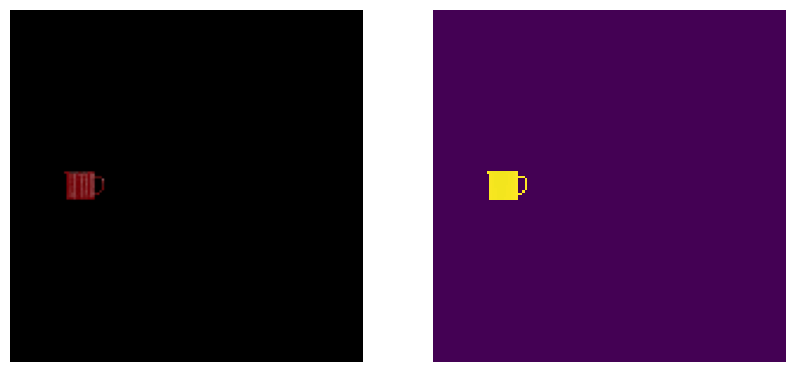

In [11]:
N = len(linear_poses)

all_images = [
        render_rgbd_many(r,
        transformed_vertices,
        object_library.faces,
        jnp.tile(object_library.attributes, (N,1,1)),
    )
    for r in renderers
]
images = all_images[1]
gt_image = images[0]
print(gt_image.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# Display the first image in the first subplot
ax1.imshow(gt_image[...,:3])
ax1.axis('off')  # Hide the axis

# Display the second image in the second subplot
ax2.matshow(gt_image[...,3])
ax2.axis('off')  # Hide the axis


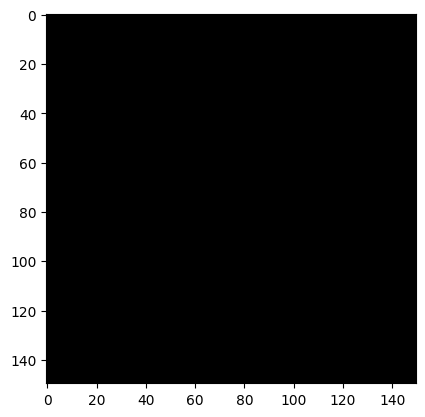

In [12]:
plt.imshow(images[-1,...,:3])